In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import wordcloud
import gensim
import pyLDAvis

In [112]:
from TCSP import read_stopwords_list

### Keyword - Topic reference table

| 民主与公义 (Democracy and Justice) | 抗议与抗争 (Protest and Resistance) | 政府与治理 (Government and Governance) |
|------------------------------------|--------------------------------------|----------------------------------------|
| 民主 (Democracy)                   | 示威者 (Protesters)                  | 政府 (Government)                      |
| **公义 (Justice)**                     | 示威 (Protest)                       | 特首 (Chief Executive)                 |
| 公平 (Fairness)                    | **抗争 (Resistance)**                    | 黑社会 (Triads)                        |
| 投票 (Voting)                    | 文宣 (Propaganda)                    | 滲透 (Infiltration)                    |
| 利益 (Interest)                    | 打壓 (Suppression)                   | 極權 (Authoritarianism)                |
| 保衛 (Defense)                     | **对抗 (Confrontation)**                 |                                        |
| 普選 (General Election)            | 落街 (Hit the Streets)               |

In [159]:
# from gensim.models import ldaseqmodel
# from gensim.corpora import Dictionary, bleicorpus
# from gensim.matutils import hellinger

In [106]:
# for chinese character display
#!pip install -U mplfonts
from mplfonts.bin.cli import init
init()

c:\Users\Annii\anaconda3\Lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(
c:\Users\Annii\anaconda3\Lib\site-packages\fire\core.py:59: DeprecationWarning: 'pipes' is deprecated and slated for removal in Python 3.13
  import pipes


## Data Cleaning
read json file

In [61]:
def read_json(filepath):
    df = pd.DataFrame(columns=['time', 'support', 'against', 'post_id', 'year', 'month', 'keyword', 'cleaned_text']) #GovtoAuthon proRest: keyword; other file: keywords

    with open(filepath, 'r') as file:

        for line in file:
            data = json.loads(line)
            
            df = pd.concat([df, pd.DataFrame([data], columns=df.columns)], ignore_index=True)
    
    return df

In [8]:
#Democracy and Justice
democracy = read_json(r'..\clean data\Democracy_cleaned.json')
fairness = read_json(r'..\clean data\Fairness_cleaned.json')
voting = read_json(r'..\clean data\voting_cleaned.json')
interest = read_json(r'..\clean data\Interest_cleaned.json')
defense = read_json(r'..\clean data\Defense_cleaned.json')
general_election = read_json(r'..\clean data\General Election_cleaned.json')

In [75]:
DJ = pd.concat([democracy, fairness, voting, interest, defense, general_election], ignore_index=True)

In [34]:
#Protest and Resistance
HitStreet = read_json(r'..\clean data\HitStreet_cleaned.json')
Propaganda = read_json(r'..\clean data\Propaganda_cleaned.json')
Suppression = read_json(r'..\clean data\Suppression_cleaned.json')

C:\Users\Annii\AppData\Local\Temp\ipykernel_1560\3510769645.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([data], columns=df.columns)], ignore_index=True)


In [62]:
proRest = read_json(r'..\clean data\proRest_cleaned.json')
proRest = proRest.rename(columns={'keyword': 'keywords'})

C:\Users\Annii\AppData\Local\Temp\ipykernel_1560\3239288087.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([data], columns=df.columns)], ignore_index=True)


In [81]:
proRest = proRest.rename(columns={'keyword': 'keywords'})

In [69]:
Protest = proRest[proRest['keyword'] == '示威']
Protesters = proRest[proRest['keyword'] == '示威者']

In [82]:
PR = pd.concat([HitStreet, Propaganda, Suppression, proRest], ignore_index=True)

In [48]:
#Government and Governance
Authoritarianism = read_json(r'..\clean data\Authoritarianism_cleaned.json')
Infiltration = read_json(r'..\clean data\Infiltration (1)_cleaned.json')

In [63]:
GovtoAuthon = read_json(r'..\clean data\GovtoAuthon_cleaned.json')
GovtoAuthon = GovtoAuthon.rename(columns={'keyword': 'keywords'})

In [71]:
Triads = GovtoAuthon[GovtoAuthon['keyword'] == '黑社会']
Chief_Executive = GovtoAuthon[GovtoAuthon['keyword'] == '特首']
Government = GovtoAuthon[GovtoAuthon['keyword'] == '政府']

In [89]:
GG = pd.concat([Authoritarianism, Infiltration, GovtoAuthon], ignore_index=True)

In [92]:
# keyword error when scraping; do some replacement
replacement_dict = {'政府': 'Government', '特首': 'Chief_Executive', '黑社会':'Triads', '極權':'Authoritarianism'}
GG['keywords'] = GG['keywords'].replace(replacement_dict)

In [58]:
Infiltration['keywords'] = 'Infiltration'

In [93]:
GG.keywords.unique()

array(['Authoritarianism', 'Infiltration', 'Government',
       'Chief_Executive', 'Triads'], dtype=object)

by year and month

In [94]:
def split_df_by_year_month(df):

    result_dict = {}

    grouped_by_year = df.groupby('year')
    
    for year, year_group_df in grouped_by_year:

        grouped_by_month = year_group_df.groupby('month')     
        year_data = {}
        year_data['all_year'] = year_group_df
        
        for month, month_group_df in grouped_by_month:
            year_data[month] = month_group_df
            
        result_dict[year] = year_data
    
    return result_dict

In [89]:
year_month = split_df_by_year_month(df)

In [155]:
year_month[2016].keys()

dict_keys(['all_year', 11, 12])

extarct keywords

In [95]:
def extarct_keywords(df):
    
    test = df['cleaned_text'].tolist()
    merged_list = np.concatenate(test)

    return merged_list

In [97]:
GG #PR DJ

,time,support,against,post_id,year,month,keywords,cleaned_text
0,2019/09,2,0,1592998,2019,9,Authoritarianism,"[借, 個位, 逐步, 細節, 整合, 推到, 文宣, 新屋嶺, 雨傘, 五, 週年, 放飛..."
1,2019/09,0,1,1592998,2019,9,Authoritarianism,"[顯示更多, 嘩, 樓主, 頂住, 唔好, 快, 槍, 唔過, 一萬, 正皮, 上熱門, 唔..."
2,2019/09,1,0,1592998,2019,9,Authoritarianism,"[香港, 加油, 一齊, 黎, 一齊, 走, 光復, 香港時代, 革命, 五大, 訴求, 缺..."
3,2019/09,1,0,1592998,2019,9,Authoritarianism,"[每日, 推]"
4,2019/09,1,0,1592998,2019,9,Authoritarianism,"[實驗, 一下, 要點, 推, 先, 推到, 上去, 好, 快, 架, 咋, 搵, 屋企人,..."
...,...,...,...,...,...,...,...,...
17891,2021/06,1,0,2564038,2021,6,Authoritarianism,[]
17892,2021/01,0,0,2359254,2021,1,Authoritarianism,"[留名, 得閒, 睇下]"
17893,2021/01,0,0,2359254,2021,1,Authoritarianism,"[見, 鹽, 叔, 推]"
17894,2020/08,2,0,2168745,2020,8,Authoritarianism,"[唔記得, 戴頭盔, 網上, 消息, 拼湊, 如, 遺漏, 請, 補充, 泰國, 前, 拉,..."


In [98]:
GG_keywords = extarct_keywords(GG)
PR_keywords = extarct_keywords(PR)
DJ_keywords = extarct_keywords(DJ)

In [107]:
def dic_to_df(dic):  #for distribution / frequency use

    rows = []

    for year, year_data in dic.items():
        for month, df in year_data.items():
            if month != 'all_year':

                cleaned_text = extarct_keywords(df)
                rows.append({'year': year, 'month': month, 'cleaned_text': cleaned_text})

    new_df = pd.DataFrame(rows)

    return new_df

In [108]:
Democracy = dic_to_df(year_month)

In [ ]:
Democracy

stop word

In [126]:
stopword = read_stopwords_list()
stopword.extend(['楼主', '分享自', '討論區', '香港']) #add words that not/too related to our topic

In [127]:
GG_cleanword = [word for word in GG_keywords if word not in stopword]
PR_cleanword = [word for word in PR_keywords if word not in stopword]
DJ_cleanword = [word for word in DJ_keywords if word not in stopword]

word count

In [109]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:

        if word in wordCounts:
            wordCounts[word] += 1
        else:
            wordCounts[word] = 1

    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [158]:
countedWords = wordCounter(DJ_cleanword)
countedWords.sort_values('count', ascending=False, inplace=True)
#countedWords['word'][:500]

translation

In [133]:
import requests, uuid, json

subscription_key = '27821efaf9b1401c886547be7b6898bd'
endpoint = 'https://api.cognitive.microsofttranslator.com/'
location = 'northcentralus'

# Build the request headers
headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Ocp-Apim-Subscription-Region': location,
    'Content-type': 'application/json',
    'X-ClientTraceId': str(uuid.uuid4())
}

# Build the request body
path = '/translate?api-version=3.0'
params = '&from=yue&to=en'  # Translate from Cantonese to English, adjust as needed
constructed_url = endpoint + path + params

In [159]:
# Adjusted list of Cantonese texts with keywords
texts_for_translation = countedWords['word'][:150]

# Prepare texts for translation
texts_for_translation = [{"text": text} for text in texts_for_translation]

In [160]:
# Attempt to send the request and get the response
try:
    response = requests.post(constructed_url, headers=headers, json=texts_for_translation)
    response.raise_for_status()  # Raises an exception if the response status code is not 200
    translations = response.json()

    # Extract translated texts and include keywords
    translated_texts = [translation['translations'][0]['text'] for translation in translations]

    print("Translations saved to JSON file successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request error: {e}")
except json.decoder.JSONDecodeError:
    print("Error decoding JSON response")


Translations saved to JSON file successfully.


In [161]:
DJ_translate = translated_texts

frequency distribution (但目前只有单个的frequency，获得全部的？画图？)

In [ ]:
Democracy['cleaned_text']

In [119]:
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in merged_list)) # len(w) 是每个词的长度，英文里是letters，中文是每个词由多少字组成

In [127]:
whcfdist[5]

FreqDist({'女仔無啦啦': 51, '美國民主黨': 22, '蔣介石好似': 15, '收得律師信': 15, '泛民支持者': 14, '香港民主黨': 14, '中間自由派': 13, '意識形態上': 13, '蔣介石明顯': 12, '解決問題既': 11, ...})

In [131]:
from nltk.probability import ConditionalProbDist, ELEProbDist

In [134]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist, 5321) #not sure about the bin

In [136]:
print(whcpdist[2].max())
print(whcpdist[2].prob(whcpdist[2].max()))

民主
0.009865569574968697


wordcloud

In [104]:
custom_font_path = r'C:\Users\Annii\Documents\HL\Study\UChicago\24 Winter\122\msyh.ttc'
#custom_font = FontProperties(fname=custom_font_path)


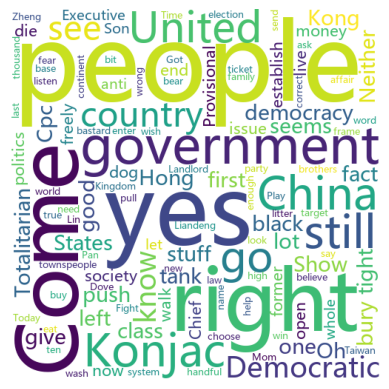

In [157]:
wc = wordcloud.WordCloud(font_path=custom_font_path, background_color="white", max_words=150, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(GG_translate))
plt.imshow(wc)
plt.axis("off")
plt.savefig("Government and Governance_E.png", format = 'png')

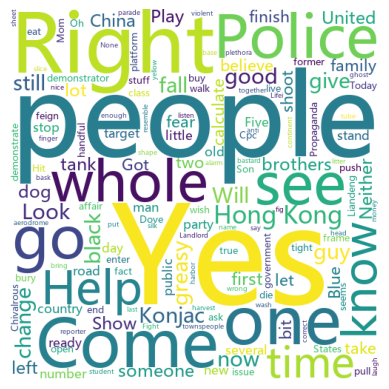

In [152]:
wc = wordcloud.WordCloud(font_path=custom_font_path, background_color="white", max_words=150, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(PR_translate))
plt.imshow(wc)
plt.axis("off")
plt.savefig("Protest and Resistance_E.png", format = 'png')

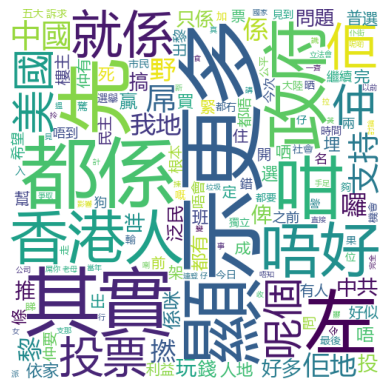

In [165]:
wc = wordcloud.WordCloud(font_path=custom_font_path, background_color="white", max_words=150, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(DJ_cleanword))
plt.imshow(wc)
plt.axis("off")
plt.savefig("Democracy and Justice_C.png", format = 'png')

DTM

What is a time-slice?
A very important input for DTM to work is the time_slice input. It should be a list which contains the number of documents in each time-slice. In our case, the first month had 438 articles, the second 430 and the last month had 456 articles. This means we'd need an input which looks like this: time_slice = [438, 430, 456]. Technically, a time-slice can be a month, year, or any way you wish to split up the number of documents in your corpus, time-based.

Once you have your corpus, id2word and time_slice ready, we're good to go!

In [162]:
Democracy

,year,month,cleaned_text
0,2016,11,"[請, 容許, 打, 比喻, 民主制度, 是, 人, 好用, 速度, 快, 最新, 有效率,..."
1,2016,12,"[肥婆, 問題, 一樣, 野, 其實, 自由, 民主, 係咪, 對立, 咩叫, 自由, 即使..."
2,2017,2,"[各位, 巴絲, 問下, 大家, 有無, 民主國家, 推翻, 左, 民意, 決定, 既例子,..."
3,2017,3,"[特首, 選舉, 民間, 全民投票, 特首, 民, 投, 民意, 民主派, 與, 民主運動,..."
4,2017,5,[然後]
5,2017,7,"[香港, 民主, 對泛民, 主, 派, 好處]"
6,2018,1,"[大躍進, 無, 躍進, 共產黨, 無, 共產, 文化大革命, 消滅, 文化, 民主黨, 出..."
7,2018,3,"[虛, 偽, 既, 代表, 范, 國威, 點睇, 三, 一一, 白票, 廢票, 梁, 耀, ..."
8,2018,4,"[全世界, 民主國家, 唔好, 似, 美國, 對付, 北韓, 對, 中國, 香港, 全面, ..."
9,2018,11,"[民主, 也是, 壞處, 人類, 是, 貪婪, 的, 若, 候選人, 能, 給, 很多, 錢..."


在这里我们将每个关键词一个月的帖子作为“一篇文章”，并且以每个主题为单位进行分析，并且将一个time-slice定义为一年。也就是说，对于下面democracy这个sample来说（其实是一个关键词，但这里我们作为示例来test code是否能正常运行），一共有2016-2023七个slice，每个slice里共有若干切片。首先我们将time-slice（即每年有数据的月份数量）统计出来

In [169]:
time_slice = Democracy.groupby('year').size().tolist()
time_slice

[2, 4, 4, 10, 8, 5, 5, 2]

In [179]:
#dictionary
dictionary = Dictionary(df['cleaned_text'])

In [182]:
# corpus
corpus = [dictionary.doc2bow(text) for text in Democracy['cleaned_text']]

In [183]:
# Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [184]:
#model
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice) #1. run time 2. num_topic and explination

c:\Users\Annii\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


In [189]:
ldaseq.print_topics(time=0)[2]

[('泛民', 0.015842576432363),
 ('熱狗', 0.01185510992277538),
 ('顯示更多', 0.008533407214354487),
 ('但', 0.007414544818286682),
 ('先', 0.006790710908352615),
 ('屌', 0.005767365328485333),
 ('既', 0.005452504519719194),
 ('建制', 0.0049828012499801375),
 ('就係', 0.004714685768591016),
 ('啦', 0.004583857291387607),
 ('依家', 0.004581362460636705),
 ('屌泛民', 0.004529738232910154),
 ('中共', 0.0041071718486176715),
 ('其實', 0.004055728124696849),
 ('兩', 0.0039185829472337666),
 ('選舉', 0.0038487161806154964),
 ('左', 0.0036645425059785492),
 ('地', 0.0036250687832812454),
 ('抗爭', 0.0035972050038646924),
 ('香港', 0.0033508817122975517)]

In [190]:
ldaseq.print_topic_times(topic=0)

[[('的', 0.017046042764609918),
  ('啦', 0.013050915350312886),
  ('撚', 0.009093713882208662),
  ('屌', 0.008676628375696325),
  ('隻熱狗', 0.007708380896133541),
  ('老母', 0.007665775618225907),
  ('香港', 0.007620219209115005),
  ('民主黨賣', 0.007445311156475825),
  ('在', 0.007221837936236598),
  ('閪', 0.007198956364471928),
  ('推', 0.007024536920394372),
  ('開', 0.0069642789432763225),
  ('分化', 0.00629395986197216),
  ('熱狗仔', 0.005896621453219526),
  ('能', 0.005516722471819745),
  ('是', 0.005373596273178692),
  ('走', 0.005248067003634871),
  ('樓主', 0.004911215705904866),
  ('沒有', 0.004633224425454615),
  ('屌民主黨', 0.004514839836018335)],
 [('的', 0.017077285564997283),
  ('啦', 0.013080762603376548),
  ('撚', 0.009109051928533564),
  ('屌', 0.00869348282150854),
  ('隻熱狗', 0.007722290564183899),
  ('老母', 0.007679170703724977),
  ('香港', 0.0076323797439411855),
  ('民主黨賣', 0.007458327575090048),
  ('在', 0.007232497541623302),
  ('閪', 0.007210926578868889),
  ('推', 0.007036592459603567),
  ('開', 0.006974

In [217]:
def plot_word_changes(data, min_occurrences):
    plt.figure(figsize=(10, 6))  

    words_count = {}  

    for sublist in data:
        for item in sublist:
            word = item[0]
            words_count[word] = words_count.get(word, 0) + 1

    for word, count in words_count.items():
        if count >= min_occurrences:
            x = []  
            y = []  
            for sublist in data:
                for item in sublist:
                    if item[0] == word: 
                        x.append(data.index(sublist))  
                        y.append(item[1] * 1000) 
            plt.plot(x, y, label=word) 
    plt.xlabel('Time')  
    plt.ylabel('Value') 
    plt.title('Word Changes Over Time')  
    plt.legend() 
    plt.grid(True)  
    plt.show()  
# frequency change little

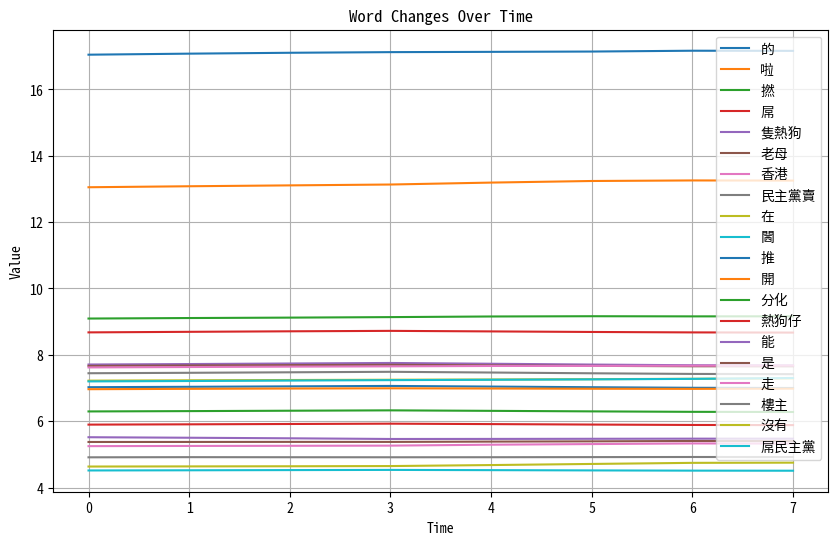

In [218]:
plot_word_changes(ldaseq.print_topic_times(topic=0), 7)

In [193]:
ldaseq.save('dtm_test')
#dtm_model = DtmModel.load('dtm_test')

In [197]:
#visualization in pyldavis
# from gensim.models.wrappers.dtmmodel import DtmModel
# from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

# dtm_path = "/Users/bhargavvader/Downloads/dtm_release/dtm/main"
# dtm_model = DtmModel(dtm_path, corpus, time_slice, num_topics=5, id2word=dictionary, initialize_lda=True)
# dtm_model.save('dtm_news')

# if we've saved before simply load the model
#dtm_model = DtmModel.load('dtm_news')

In [198]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [75]:
merged_list #all democracy data

array(['總之', '用', '建制派', ..., '垃圾', '中', '垃圾'], dtype='<U32')

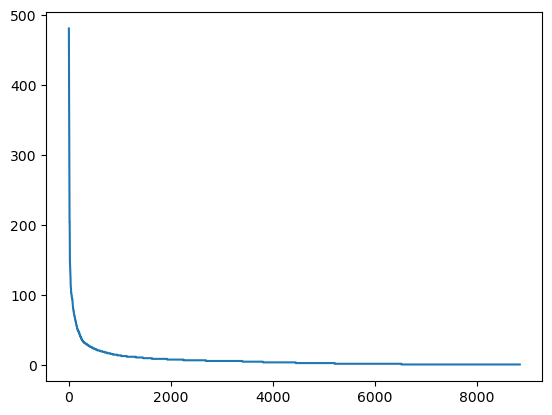

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

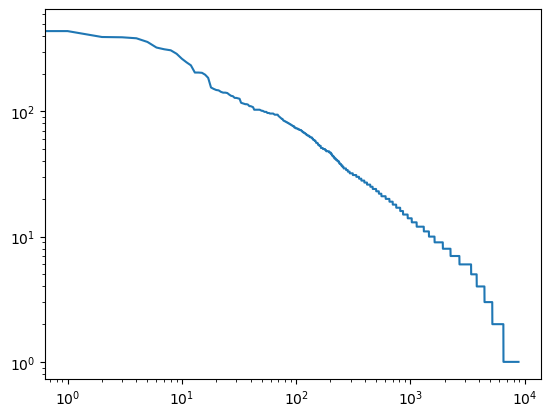

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [ ]:
countsDict = {}
for word in merged_list:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]